# Custom Array Cabling Layout Example
## Dudgeon Windfarm


#### Author: Rob Hammond
#### Date: 4 May 2020
#### Update: 27 October 2025

##### Data source: Dudgeon Wind Farm turbine locations from their publicly available [Call to Mariners](http://dudgeonoffshorewind.co.uk/news/notices/Dudgeon%20-%20Notice%20to%20Mariners%20wk25.pdf)


This notebook will guide you through four of the main use cases on using the custom array cable layout functionality of `ORBIT` for when custom turbine locations, cable lengths or burial speeds are needed.

**Note:** All array cable layout files are CSVs, which can be edited in Microsoft Excel.

**Update:** This example was updated to work with ORBIT >= 1.0.0

In [1]:
import os
from copy import deepcopy
from pprint import pprint

import numpy as np
import pandas as pd

import ORBIT
from ORBIT import ProjectManager
from ORBIT.core import library
from ORBIT.phases.design import CustomArraySystemDesign
from ORBIT.phases.install import ArrayCableInstallation

# initialize the library location
library.initialize_library("../library")

ORBIT library intialized at '/Users/rhammond/GitHub_Public/ORBIT/library'


## Contents
 - [Overview](#overview): How to use the inputs
 - [Case 1](#case_1): Needing to know what to collect
 - [Case 2](#case_2): Coordinates with a straight-line distance for cable length
 - [Case 3](#case_3): Using distance from a reference point
 - [Case 4](#case_4): Adjusting for exclusions in the cable paths
 - [Case 5](#case_5): Fully customizing the cabling parameters
 - [Applying the cases to `ArrayCableInstallation`](#running)
 - [Using `ProjectManager` to model the entire process](#project_manager)

<a id="overview"></a>
## Overview

#### Before starting it is important to demonstrate how to create a configuration file or how to set up a customized layout file.

In the highest level of this repository there is a folder called `library` where all of the example data for this notebook is going to be stored. While any folder could be used, the folder structure must be strictly adhered to. More details on this structure can be found [here](https://github.com/WISDEM/ORBIT/blob/master/ORBIT/library.py#L9-L23).

For this example of how to setup a configuration, I will be using the file `<path>/ORBIT/library/project/config/example_custom_array_simple.yaml`. YAML' files are used for configuration throughout this codebase due their ease of encoding and loading `Python` data types.

Now, we will load the configuration file and display it below.

In [2]:
config = library.extract_library_specs("config", "example_custom_array_simple")
pprint(config)

{'array_system_design': {'cables': ['XLPE_400mm_33kV',
                                    'XLPE_630mm_33kV',
                                    'XLPE_630mm_220kV'],
                         'location_data': 'dudgeon_array'},
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'site': {'depth': 20},
 'turbine': 'SWT_6MW_154m_110m'}


#### A couple of things to notice in the configuration file for a custom array layout:
```python
{
    # Array cabling system specific data configuration
    'array_system_design': {
        
        # A list of array cable YAML files that can be found in library/project/cables/ as
        # XLPE_400mm_33kV.yaml, XLPE_630mm_33kV.yaml, and XLPE_630mm_220kV.yaml
        'cables': ['XLPE_400mm_33kV', 'XLPE_630mm_33kV', 'XLPE_630mm_220kV'],
        
        # A YAML file named dudgeon_array.csv found in the same location
        'location_data': 'dudgeon_array'},
    
    # We are using a custom layout and the Dudgeon contains 67 turbines
    'plant': {'layout': 'custom', 'num_turbines': 67},
    
    # The average water depth at the site
    'site': {'depth': 20},
    
    # Turbine details (optional for custom)
    'turbine': 'SWT_6MW_154m_110m'
}
```

#### Now, let's see what is contained within the additional files from the configuration dictionary

It should be noted that running the design class extracts the data from the files automatically to produce the below output.

In [3]:
array = CustomArraySystemDesign(config)
array.run()
pprint(array.config)

{'array_system_design': {'cables': {'XLPE_400mm_33kV': {'ac_resistance': 0.06, 'capacitance': 225, 'conductor_size': 400, 'cost_per_km': 364352, 'current_capacity': 600, 'inductance': 0.375, 'linear_density': 35, 'name': 'XLPE_400mm_33kV', 'rated_voltage': 33}, 'XLPE_630mm_33kV': {'ac_resistance': 0.04, 'capacitance': 300, 'conductor_size': 630, 'cost_per_km': 546528, 'current_capacity': 700, 'inductance': 0.35, 'linear_density': 42.5, 'cable_type': 'HVAC', 'name': 'XLPE_630mm_33kV', 'rated_voltage': 33}, 'XLPE_630mm_220kV': {'ac_resistance': 0.25, 'capacitance': 160, 'conductor_size': 630, 'cost_per_km': 853557, 'current_capacity': 715, 'inductance': 0.41, 'linear_density': 96, 'rated_voltage': 220, 'cable_type': 'HVAC', 'name': 'XLPE_630mm_220kV'}}, 'location_data': 'dudgeon_array'}, 'plant': {'layout': 'custom', 'num_turbines': 67}, 'site': {'depth': 20}, 'turbine': {'blade': {'deck_space': 100, 'length': 75, 'mass': 100}, 'hub_height': 110, 'nacelle': {'deck_space': 200, 'mass': 36

Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.

#### When the `dudgeon_array.csv` file is loaded, it is not passed back into the configuration dictionary, so let's dissect this file:

1. The file must have all of the columns shown below (not case-sensitive).
 - All columns must be completely filled out for turbines (note on substation(s) following).
 - `cable_length` and `bury_speed` are optional and if these are not known, simply fill with a 0.
2. A latitude and longitude must be provided for all turbines and substation(s). This can either be a WGS-84 decimal coordinate or a distance-based "coordinate" where latitude and longitude are the distances from some reference point, in kilometers; see [Case 3](#case_3) for more details.
2. Define the offshore substation(s)
 - For each substation,  the values in columns `id` and `substation_id` _must_ be the same.
 - There is no need to fill in any data for the columns `String`, `Order`, `cable_length` and `bury_speed`.
3. Define the turbines
 - Each turbine should have a reference to its substation in the `substation_id` column.
     - In this example, there is one substaion, so all of the values are "DOW_OSS".
 - `string` and `order` should be 0-indexed for their ordering and not skip any numbers.
     - In this example, the strings are ordered in clock-wise order starting from the string with turbines labeled with an "A" in the [Call to Mariners](http://dudgeonoffshorewind.co.uk/news/notices/Dudgeon%20-%20Notice%20to%20Mariners%20wk25.pdf)
 - The ordering on a string should travel from substation to the farthest end of the cable

In [4]:
df = pd.read_csv("../library/cables/dudgeon_array.csv").fillna("")
df.sort_values(by=["String", "Order"])

,id,substation_id,name,Longitude,Latitude,String,Order,cable_length,bury_speed
1,DAE_A1,DOW_OSS,DAE_A1,1.358783,53.243950,0.0,0.0,0.0,0.0
2,DAD_A2,DOW_OSS,DAD_A2,1.349033,53.248467,0.0,1.0,0.0,0.0
3,DAC_A3,DOW_OSS,DAC_A3,1.339283,53.252983,0.0,2.0,0.0,0.0
4,DAB_A4,DOW_OSS,DAB_A4,1.329550,53.257500,0.0,3.0,0.0,0.0
5,DAA_A5,DOW_OSS,DAA_A5,1.319800,53.262017,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
59,DAF_L2,DOW_OSS,DAF_L2,1.368533,53.239433,11.0,1.0,0.0,0.0
60,DAG_L3,DOW_OSS,DAG_L3,1.378250,53.234917,11.0,2.0,0.0,0.0
61,DAH_L4,DOW_OSS,DAH_L4,1.388000,53.230400,11.0,3.0,0.0,0.0
62,DAJ_L5,DOW_OSS,DAJ_L5,1.397750,53.225883,11.0,4.0,0.0,0.0


<a id="case_1"></a>
## Case 1: Needing to know what to collect

Here we know that we need to have a csv created to input all the data but need to see what data is necessary to collect.


First, we need to load in the configuration dictionary. Then, we will create a "starter" file that can be filled in for a new project, which will be saved in the "library".

In [5]:
config = library.extract_library_specs("config", "example_custom_array_no_data")
pprint(config)
print()

array = CustomArraySystemDesign(config)
save_path = array.config["array_system_design"]["location_data"]
array.create_project_csv(save_path)

{'array_system_design': {'cables': ['XLPE_400mm_33kV', 'XLPE_630mm_33kV'],
                         'location_data': 'dudgeon_array_no_data'},
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'site': {'depth': 20},
 'turbine': 'SWT_6MW_154m_110m'}

+--------------------------------+
|     PROJECT SPECIFICATIONS     |
+---------------------------+----+
| N turbines full string    |  5 |
| N full strings            | 13 |
| N turbines partial string |  2 |
| N partial strings         |  1 |
+---------------------------+----+
Saving custom array to: <library_path>/cables/dudgeon_array_no_data.csv


/Users/rhammond/GitHub_Public/ORBIT/library/cables/dudgeon_array_no_data.csv already exists, overwrite [y/n]? y


Save complete!


#### Let's take a look at the data to see what it output

**NOTE**:
 1. The offshore substation (row 0) is indicated via the `id` and `substation_id` columns being equal
 2. For substaions only the `id`, `substation_id`, `name`, `latitued`, and `longitude` are required
 3. `cable_length` and `bury_speed` are optional columns for turbines
 4. `string` and `order` are filled out to maximize the length of a string given the cable(s) provided so in this case we can have up to 6 turbines in a string. **These are also, very importantly, starting their numbering with 0.**

In [6]:
dudgeon_array_no_data = pd.read_csv("../library/cables/dudgeon_array_no_data.csv")

In [7]:
dudgeon_array_no_data

,id,substation_id,name,latitude,longitude,string,order,cable_length,bury_speed
0,oss1,oss1,offshore_substation,0.0,0.0,NaN,NaN,NaN,NaN
1,t0,oss1,turbine-0,0.0,0.0,0.0,0.0,0.0,0.0
2,t1,oss1,turbine-1,0.0,0.0,0.0,1.0,0.0,0.0
3,t2,oss1,turbine-2,0.0,0.0,0.0,2.0,0.0,0.0
4,t3,oss1,turbine-3,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
63,t62,oss1,turbine-62,0.0,0.0,12.0,2.0,0.0,0.0
64,t63,oss1,turbine-63,0.0,0.0,12.0,3.0,0.0,0.0
65,t64,oss1,turbine-64,0.0,0.0,12.0,4.0,0.0,0.0
66,t65,oss1,turbine-65,0.0,0.0,13.0,0.0,0.0,0.0


<a id="case_2"></a>
## Case 2: Standard straight-line distance for cable lengths

Here we have the turbine and offshore substation locations that were extracted from the data source in the header but nothing specific regarding the actual cable lengths or the cable burial speeds for each section.

In [8]:
config = library.extract_library_specs("config", "example_custom_array_simple")
pprint(config)

{'array_system_design': {'cables': ['XLPE_400mm_33kV',
                                    'XLPE_630mm_33kV',
                                    'XLPE_630mm_220kV'],
                         'location_data': 'dudgeon_array'},
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'site': {'depth': 20},
 'turbine': 'SWT_6MW_154m_110m'}


In [9]:
array = CustomArraySystemDesign(config)
array.run()

Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.

#### Let's take a look at the data to see what it output

**NOTE**: Here the cable length and bury speed are still set to 0 to indicate that they are unknown

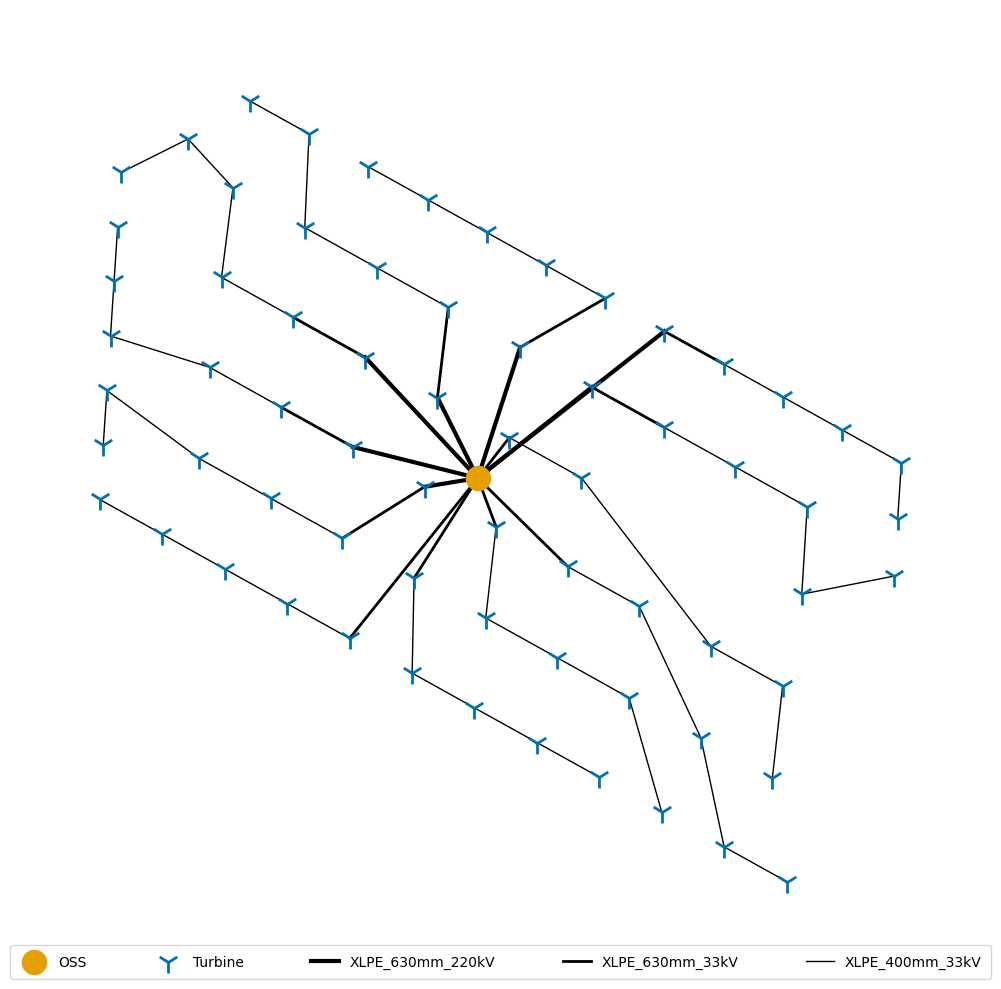

In [10]:
array.plot_array_system(show=True)

#### It should be noted here that the the latitude and longitude here are WGS-84 decimal coordinates

In [11]:
array.location_data

,id,substation_id,substation_name,substation_latitude,substation_longitude,turbine_name,turbine_latitude,turbine_longitude,string,order,cable_length,bury_speed
0,DAE_A1,DOW_OSS,DOW_OSS,53.2648,1.378767,DAE_A1,53.243950,1.358783,0,0,0.0,0.0
1,DAD_A2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAD_A2,53.248467,1.349033,0,1,0.0,0.0
2,DAC_A3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAC_A3,53.252983,1.339283,0,2,0.0,0.0
3,DAB_A4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAB_A4,53.257500,1.329550,0,3,0.0,0.0
4,DAA_A5,DOW_OSS,DOW_OSS,53.2648,1.378767,DAA_A5,53.262017,1.319800,0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
57,DCE_L1,DOW_OSS,DOW_OSS,53.2648,1.378767,DCE_L1,53.251783,1.368833,11,0,0.0,0.0
58,DAF_L2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAF_L2,53.239433,1.368533,11,1,0.0,0.0
59,DAG_L3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAG_L3,53.234917,1.378250,11,2,0.0,0.0
60,DAH_L4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAH_L4,53.230400,1.388000,11,3,0.0,0.0


#### Now let's look at the cost for this cabling setup by each type of cable as well as the total cost

In [12]:
print(f"{'Cable Type':<16}|  {'Cost in USD':>15}")
for cable, cost in array.cost_by_type.items():
    print(f"{cable:<16}| ${cost:>15,.2f}")
    
print(f"{'Total':<16}| ${array.total_cable_cost:>15,.2f}")

Cable Type      |      Cost in USD
XLPE_400mm_33kV | $  18,701,160.61
XLPE_630mm_33kV | $   8,144,423.11
XLPE_630mm_220kV| $  10,361,949.24
Total           | $  37,207,532.97


<a id="case_3"></a>
## Case 3: Distance-based "coordinate" system

In this case, we will consider each turbine and substation on a distance-based "coordinate" system where the longitude and latitude are the longitudinal (x direction) and latitudinal (y direction) **distances**, in kilometers, from a common reference point. We are still using the Dudgeon data, but the distances were computed outside of this example and the details are not be included.

Below, we can see that the input file is still encoded in the exact same manner as [Case 2](#case_2), but latitude and longitude are relative distances and not proper coordinates.

In [13]:
df = pd.read_csv("../library/cables/dudgeon_distance_based.csv", index_col=False).fillna("")
df

,id,substation_id,name,longitude,latitude,string,order,cable_length,bury_speed
0,DOW_OSS,DOW_OSS,DOW_OSS,16.229909,35.769173,,,,
1,DAE_A1,DOW_OSS,DAE_A1,14.890845,33.450759,0.0,0.0,0.0,0.0
2,DAD_A2,DOW_OSS,DAD_A2,14.237528,33.953026,0.0,1.0,0.0,0.0
3,DAC_A3,DOW_OSS,DAC_A3,13.584211,34.455182,0.0,2.0,0.0,0.0
4,DAB_A4,DOW_OSS,DAB_A4,12.932034,34.957450,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
63,DCE_L1,DOW_OSS,DCE_L1,15.564263,34.321749,11.0,0.0,0.0,0.0
64,DAF_L2,DOW_OSS,DAF_L2,15.544161,32.948491,11.0,1.0,0.0,0.0
65,DAG_L3,DOW_OSS,DAG_L3,16.195266,32.446335,11.0,2.0,0.0,0.0
66,DAH_L4,DOW_OSS,DAH_L4,16.848583,31.944067,11.0,3.0,0.0,0.0


#### For this case we also add the `distance` argument to the `array_system_design` and set it to `True` to indicate we are dealing with distances.

In [14]:
config = library.extract_library_specs("config", "example_custom_array_simple_distance_based")
pprint(config)

{'array_system_design': {'cables': ['XLPE_400mm_33kV',
                                    'XLPE_630mm_33kV',
                                    'XLPE_630mm_220kV'],
                         'distance': True,
                         'location_data': 'dudgeon_distance_based'},
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'site': {'depth': 20},
 'turbine': 'SWT_6MW_154m_110m'}


#### OR we can create the flag in the function call.

**Note:** the configuration dictionary will always override this setting.

In [15]:
array_distance = CustomArraySystemDesign(config, distance=True)
array_distance.run()

Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.

#### Let's take a look at the data to see what it output

While some of the cable lengths may be slightly different, the spacing is still maintained, and we can see that this is the Dudgeon windfarm.

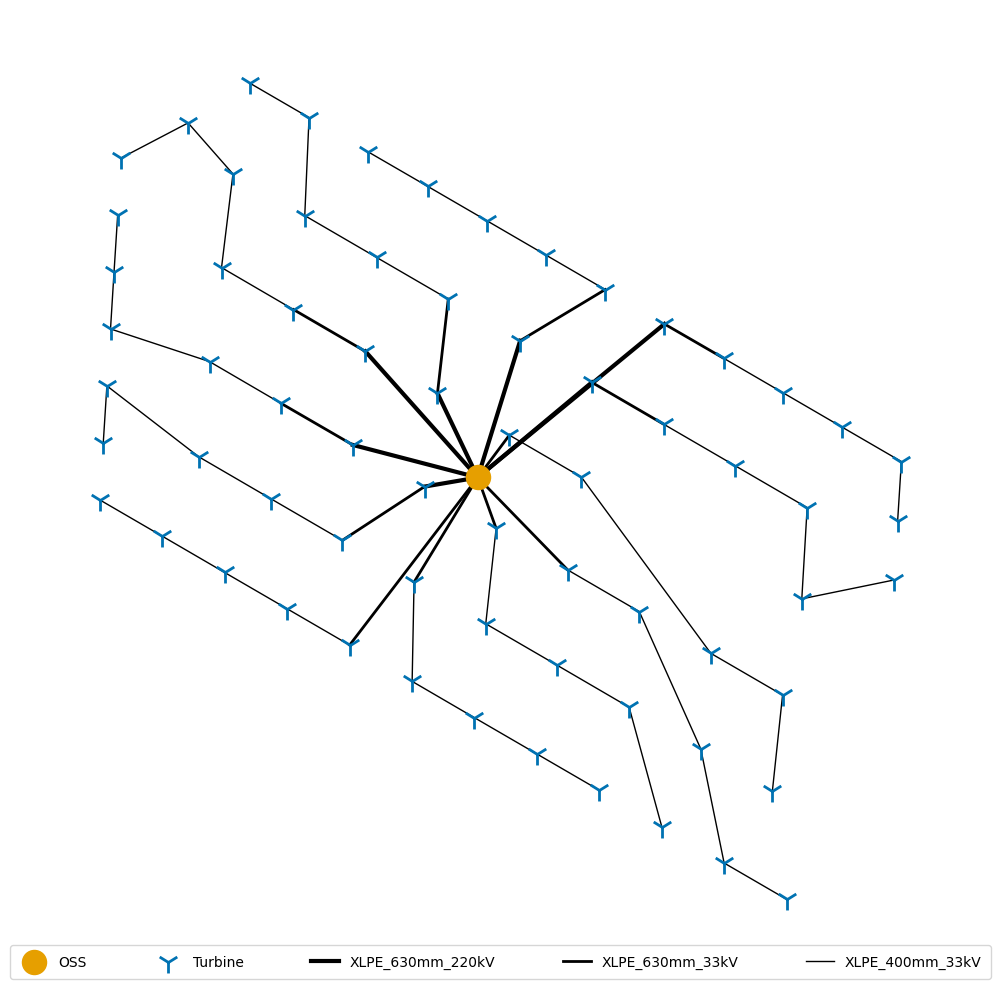

In [16]:
array_distance.plot_array_system(show=True)

#### Now let's look at the cost for this cabling setup by each type of cable as well as the total cost and compare it to the previous case

While there is a minor difference, this difference is small in comparison to the total project cost and errs in a more conservative direction.

In [17]:
print(f"{'Cable Type':<16} | {'Cost in USD (lat,lon)':>20} | {'Cost in USD (dist_lat,dist_lon)':>15}")
for (cable1, cost1), (cable2, cost2) in zip(array.cost_by_type.items(), array_distance.cost_by_type.items()):
    print(f"{cable1:<16} | ${cost1:>20,.2f} | ${cost2:>15,.2f}")
    
print(f"{'Total':<16} | ${array.total_cable_cost:>20,.2f} | ${array_distance.total_cable_cost:>15,.2f}")

Cable Type       | Cost in USD (lat,lon) | Cost in USD (dist_lat,dist_lon)
XLPE_400mm_33kV  | $       18,701,160.61 | $  18,756,091.16
XLPE_630mm_33kV  | $        8,144,423.11 | $   8,166,522.03
XLPE_630mm_220kV | $       10,361,949.24 | $  10,392,923.05
Total            | $       37,207,532.97 | $  37,315,536.24


<a id="case_4"></a>
## Case 4: We want to account for some additions to the cable lengths due to exclusion zones

This can be done with the `"average_exclusion_percent"` keyword in the configuration that can be seen below.

**Note:**
 1. There is an average  exclusion and is applied to each of the cable sections
 2. The plot won't change because it will not have details on the new paths so we'll only demonstrate the cost changes (a 4.8% increase, which is in line with the exclusion and the accounting for the site depth.

In [18]:
config = library.extract_library_specs("config", "example_custom_array_exclusions")
config

{'array_system_design': {'cables': ['XLPE_400mm_33kV',
   'XLPE_630mm_33kV',
   'XLPE_630mm_220kV'],
  'location_data': 'dudgeon_array',
  'average_exclusion_percent': 0.05},
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'site': {'depth': 20},
 'turbine': 'SWT_6MW_154m_110m'}

In [19]:
array_exclusion = CustomArraySystemDesign(config)
array_exclusion.run()

Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.

In [20]:
print(f"{'Cable Type':<16}|  {'Cost in USD':>15}")
for cable, cost in array_exclusion.cost_by_type.items():
    print(f"{cable:<16}| ${cost:>15,.2f}")
    
print(f"{'Total':<16}| ${array_exclusion.total_cable_cost:>15,.2f}")

Cable Type      |      Cost in USD
XLPE_400mm_33kV | $  19,601,240.84
XLPE_630mm_33kV | $   8,538,527.60
XLPE_630mm_220kV| $  10,868,096.91
Total           | $  39,007,865.35


<a id="case_5"></a>
## Case 5: Customize the distances 

If we look at the map in the [Call to Mariners](http://dudgeonoffshorewind.co.uk/news/notices/Dudgeon%20-%20Notice%20to%20Mariners%20wk25.pdf) there are different sized exclusions in the cables, so for this example we'll change the distances from [Case 4](#case_4) where we used an average exclusion to be a bit different in each case by using the `cable_length` column. In addition, we will utilize the `bury_speed` column to demonstrate how these columns will be used.

**Note:** this work was done outside the notebook, but can be uploaded as show in the example below.

For this example, half of the windfarm will have different soil condition, so we will use our proxy: `bury_speed` by modifying the burial speed to be fast (0.5 km/h) and slow (0.05 km/hr), respectively, to account for sandy soil and rocky soil. The purpose of this is for passing through customized parameters in the design phase to be utilized in the installation phase as will be seen in the final two examples.

In [21]:
config = library.extract_library_specs("config", "example_custom_array_custom")

# Note location_data the same one that was saved because I updated it!
config

{'array_system_design': {'cables': ['XLPE_400mm_33kV',
   'XLPE_630mm_33kV',
   'XLPE_630mm_220kV'],
  'location_data': 'dudgeon_custom'},
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'site': {'depth': 20},
 'turbine': 'SWT_6MW_154m_110m'}

In [22]:
array_custom = CustomArraySystemDesign(config)
array_custom.run()

#### Note that there are now cable lengths defined as well as burial speeds for installation

In [23]:
array_custom.location_data

,id,substation_id,substation_name,substation_latitude,substation_longitude,turbine_name,turbine_latitude,turbine_longitude,string,order,cable_length,bury_speed
0,DAE_A1,DOW_OSS,DOW_OSS,53.2648,1.378767,DAE_A1,53.243950,1.358783,0,0,3.135279,0.50
1,DAD_A2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAD_A2,53.248467,1.349033,0,1,0.993860,0.50
2,DAC_A3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAC_A3,53.252983,1.339283,0,2,0.993719,0.50
3,DAB_A4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAB_A4,53.257500,1.329550,0,3,0.992699,0.50
4,DAA_A5,DOW_OSS,DOW_OSS,53.2648,1.378767,DAA_A5,53.262017,1.319800,0,4,0.993673,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
62,DCE_L1,DOW_OSS,DOW_OSS,53.2648,1.378767,DCE_L1,53.251783,1.368833,11,0,1.712822,0.05
63,DAF_L2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAF_L2,53.239433,1.368533,11,1,1.483318,0.05
64,DAG_L3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAG_L3,53.234917,1.378250,11,2,0.901721,0.05
65,DAH_L4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAH_L4,53.230400,1.388000,11,3,0.903679,0.05


#### See also that the costs have increased again!

In [24]:
print(f"{'Cable Type':<16}|  {'Cost in USD':>15}")
for cable, cost in array_custom.cost_by_type.items():
    print(f"{cable:<16}| ${cost:>15,.2f}")
    
print(f"{'Total':<16}| ${array_custom.total_cable_cost:>15,.2f}")

Cable Type      |      Cost in USD
XLPE_400mm_33kV | $  20,841,928.36
XLPE_630mm_33kV | $   9,307,325.71
XLPE_630mm_220kV| $  10,158,477.79
Total           | $  40,307,731.86


<a id="running"></a>
# Let's run some simulations!
We can now compare cases 2-4 to see how the installation cost will vary.

#### First, we have to create a configuration dictionary for each of the 3 main cases we'll be simulating for installations, corresponding to the configuration file from the tests library. Then, we'll update eeach with the `design_result` of each of the 3 cases that we defined above.

In [25]:
base_config = library.extract_library_specs("config", "example_array_cable_install")

#Case 2
array_case2 = deepcopy(base_config)
array_case2["array_system"] = array.design_result["array_system"]

# Case 3
array_case3 = deepcopy(base_config)
array_case3["array_system"] = array_distance.design_result["array_system"]

# Case 4
array_case4 = deepcopy(base_config)
array_case4["array_system"] = array_exclusion.design_result["array_system"]

# Case 5
array_case5 = deepcopy(base_config)
array_case5["array_system"] = array_custom.design_result["array_system"]

#### Instantiate the simulations

In [26]:
sim2 = ArrayCableInstallation(array_case2)
sim3 = ArrayCableInstallation(array_case3)
sim4 = ArrayCableInstallation(array_case4)
sim5 = ArrayCableInstallation(array_case5)

#### Run the simulations

We can see that both the installation cost and the time required to complete the simulation have all increased here, which corresponds to the increased cable lengths and changes to the burial speeds defined above.

In [27]:
names = ("straight-line distance", "distance-based coordinates", "with exclusions", "custom")
simulations = (sim2, sim3, sim4, sim5)

print(f"{'Simulation':<26} | {'Cost (in USD)':>14} | {'Time (in hours)':>16}")
for name, simulation in zip(names, simulations):
    simulation.run()
    cost = simulation.installation_capex
    time = simulation.total_phase_time
    print(f"{name:<26} | ${cost:>13,.2f} | {time:>16,.0f}")

Simulation                 |  Cost (in USD) |  Time (in hours)
straight-line distance     | $24,594,075.16 |            2,372
distance-based coordinates | $24,605,520.50 |            2,373
with exclusions            | $24,784,480.17 |            2,391
custom                     | $31,792,520.58 |            3,088


<a id="project_manager"></a>
## Let's put this all together and load with a data frame

### Using `ProjectManager` we will run Case 4 from design to installation.

We'll see here at the end that we end up with the same results running a custom array cabling project piecemeal and as a whole.

In [28]:
config = library.extract_library_specs("config", "example_custom_array_project_manager")
config["array_system_design"]["location_data"] = library.extract_library_specs(
    "cables", config["array_system_design"]["location_data"], file_type="csv"
)
config

{'design_phases': ['CustomArraySystemDesign'],
 'install_phases': ['ArrayCableInstallation'],
 'plant': {'layout': 'custom', 'num_turbines': 67},
 'port': {'monthly_rate': 10000},
 'site': {'depth': 20, 'distance': 50},
 'turbine': 'SWT_6MW_154m_110m',
 'array_system_design': {'cables': ['XLPE_400mm_33kV',
   'XLPE_630mm_33kV',
   'XLPE_630mm_220kV'],
  'location_data':          id substation_id     name   latitude  longitude  string  order  \
  0   DOW_OSS       DOW_OSS  DOW_OSS  53.264800   1.378767     NaN    NaN   
  1    DAE_A1       DOW_OSS   DAE_A1  53.243950   1.358783     0.0    0.0   
  2    DAD_A2       DOW_OSS   DAD_A2  53.248467   1.349033     0.0    1.0   
  3    DAC_A3       DOW_OSS   DAC_A3  53.252983   1.339283     0.0    2.0   
  4    DAB_A4       DOW_OSS   DAB_A4  53.257500   1.329550     0.0    3.0   
  ..      ...           ...      ...        ...        ...     ...    ...   
  63   DCE_L1       DOW_OSS   DCE_L1  53.251783   1.368833    11.0    0.0   
  64   DAF_L2

In [29]:
project = ProjectManager(config)
project.run()

In [30]:
total = array_custom.total_cable_cost + sim5.installation_capex

print(f"Custom Design        | ${array_custom.total_cable_cost:>13,.2f}")
print(f"Custom Installation  | ${sim5.installation_capex:>13,.2f}")
print(f"Total Cost.          | ${total:>13,.2f}")
print(f"Project Manager Cost | ${project.bos_capex:>13,.2f}")

Custom Design        | $40,307,731.86
Custom Installation  | $31,792,520.58
Total Cost.          | $72,100,252.44
Project Manager Cost | $72,100,252.44
